<a href="https://colab.research.google.com/github/bialyy10/Uczenie_maszynowe_w_finansach_1/blob/main/Case_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd

# Pobranie danych historycznych dla Amazon
ticker = 'AMZN'
data = yf.download(ticker, start='2023-01-01', end='2024-06-05')
data.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,85.459999,86.959999,84.209999,85.820000,85.820000,76706000
2023-01-04,86.550003,86.980003,83.360001,85.139999,85.139999,68885100
2023-01-05,85.330002,85.419998,83.070000,83.120003,83.120003,67930800
2023-01-06,83.029999,86.400002,81.430000,86.080002,86.080002,83303400
2023-01-09,87.459999,89.480003,87.080002,87.360001,87.360001,65266100


In [2]:
!pip install ta
import ta

# Dodanie wskaźników technicznych
data['SMA'] = ta.trend.sma_indicator(data['Close'], window=14)
data['RSI'] = ta.momentum.rsi(data['Close'], window=14)
data['MACD'] = ta.trend.macd(data['Close'])
data.dropna(inplace=True)
data.head()


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=ea0d4fce0c6c756ec95a29a4e8556ab88af1ef35366ddfc39c8f2c4c03625829
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


,Open,High,Low,Close,Adj Close,Volume,SMA,RSI,MACD
Date,,,,,,,,,
2023-02-08,102.040001,102.669998,98.779999,100.050003,100.050003,75878300,101.371429,54.326304,3.672258
2023-02-09,101.320000,101.779999,97.570000,98.239998,98.239998,64622500,101.442143,51.135380,3.145289
2023-02-10,97.559998,98.820000,96.230003,97.610001,97.610001,52740100,101.448572,50.033806,2.646322
2023-02-13,97.849998,99.680000,96.910004,99.540001,99.540001,52841500,101.678572,53.349338,2.379196
2023-02-14,98.410004,100.919998,97.519997,99.699997,99.699997,56202900,101.858572,53.624068,2.155559


In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Przygotowanie zmiennych objaśniających i objaśnianych
X = data[['SMA', 'RSI', 'MACD']]
y = (data['Close'].shift(-1) > data['Close']).astype(int)  # Sygnał kupna/sprzedaży
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Optymalizacja hiperparametrów
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20]
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Najlepsze parametry
best_model = grid_search.best_estimator_


best_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=10)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 6.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X

<Figure size 1400x700 with 0 Axes>

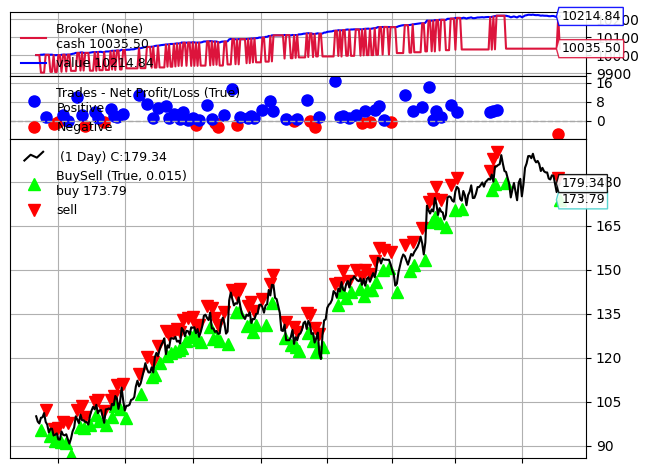

Początkowy kapitał: 10000 USD
Końcowy kapitał: 10214.84 USD


In [4]:
!pip install backtrader
import backtrader as bt
import numpy as np
import matplotlib.pyplot as plt

# Rozszerzenie PandasData
class PandasDataExtend(bt.feeds.PandasData):
    lines = ('sma', 'rsi', 'macd',)
    params = (
        ('sma', 'SMA'),
        ('rsi', 'RSI'),
        ('macd', 'MACD'),
    )

class MLStrategy(bt.Strategy):
    def __init__(self):
        self.dataclose = self.datas[0].close
        self.model = best_model
        self.sma = self.datas[0].sma
        self.rsi = self.datas[0].rsi
        self.macd = self.datas[0].macd

    def next(self):
        features = np.array([[self.sma[0], self.rsi[0], self.macd[0]]])
        signal = self.model.predict(features)
        if signal == 1 and not self.position:
            self.buy()
        elif signal == 0 and self.position:
            self.sell()

# Przygotowanie danych do backtestu
data.dropna(inplace=True)

cerebro = bt.Cerebro()
cerebro.addstrategy(MLStrategy)

# Dodanie danych do backtradera
feed = PandasDataExtend(dataname=data)
cerebro.adddata(feed)

# Ustawienie kapitału początkowego
cerebro.broker.set_cash(10000)


results = cerebro.run()

# Wizualizacja wyników
plt.figure(figsize=(14, 7))
cerebro.plot(iplot=False, volume=False)
plt.show()


print(f'Początkowy kapitał: 10000 USD')
print(f'Końcowy kapitał: {cerebro.broker.getvalue():.2f} USD')
